In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_excel('./data/GDP-CPI.xls', index_col=0)

In [6]:
df.head()

,GDP:不变价:当季同比,CPI:当月同比
指标名称,,
2000-09-30,8.8,0.0
2000-10-31,NaN,0.0
2000-11-30,NaN,1.3
2000-12-31,7.5,1.5
2001-01-31,NaN,1.2


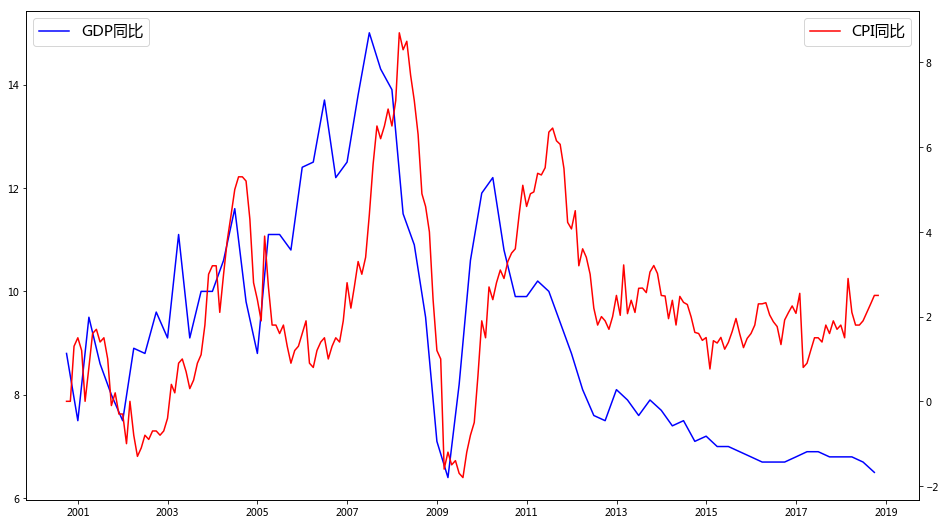

In [9]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.plot(df[u'GDP:不变价:当季同比'].dropna(), color='blue', label=u'GDP同比')
ax.legend(loc='upper left', fontsize=15)
axx = ax.twinx()
axx.plot(df[u'CPI:当月同比'], color='red', label=u'CPI同比')
axx.legend(fontsize=15)

In [54]:
num_bckts

3

In [55]:
pad_size = conf['bckt_size'] * num_bckts - g.size

In [56]:
pad_size

1

In [57]:
g_mat = np.reshape(np.pad(g, (0, pad_size), 'constant',
    constant_values=(0.0, 0.0)), (num_bckts, conf['bckt_size']))

In [58]:
g_mat

array([[1. , 2.2],
       [3. , 4. ],
       [5. , 0. ]])

In [59]:
if conf['use_l2_scl']:
    g_scl = norm(g_mat, axis=1, keepdims=True)  # L2-norm
else:
    g_scl = norm(g_mat, np.inf, axis=1, keepdims=True)  # LInf-norm

In [60]:
g_scl

array([[2.41660919],
       [5.        ],
       [5.        ]])

In [61]:
np.where(np.random.uniform(
    size=g_mat.shape) < np.abs(g_mat) / g_scl)

(array([0, 1, 1, 2], dtype=int64), array([1, 0, 1, 0], dtype=int64))

In [62]:
g_lvl = np.sign(g_mat).astype(np.int8) * np.where(np.random.uniform(
    size=g_mat.shape) < np.abs(g_mat) / g_scl, 1, 0).astype(np.int8)

In [63]:
g_lvl

array([[0, 1],
       [1, 0],
       [1, 0]], dtype=int8)

In [64]:
g_fnl = (g_scl * g_lvl).ravel()[:g.size]

In [65]:
g_fnl

array([0.        , 2.41660919, 5.        , 0.        , 5.        ])

In [66]:
idxs_nnz = np.nonzero(g_fnl)[0]

In [67]:
idxs_nnz

array([1, 2, 4], dtype=int64)

In [68]:
g_enc = np.concatenate(
    (idxs_nnz.size * np.ones((1)), idxs_nnz, g_fnl[idxs_nnz]))

In [69]:
g_enc

array([3.        , 1.        , 2.        , 4.        , 2.41660919,
       5.        , 5.        ])

# quantization

In [126]:
g = np.array([-10.5, -1., 2., 5., 15.])

In [127]:
g

array([-10.5,  -1. ,   2. ,   5. ,  15. ])

In [128]:
factor, bit = 2., 2
bound = np.power(2, bit)
min_val = - bound
max_val = bound - 1

In [129]:
min_val, max_val

(-4, 3)

In [130]:
g_factor = g / factor

In [131]:
g_factor

array([-5.25, -0.5 ,  1.  ,  2.5 ,  7.5 ])

In [132]:
g_floor = np.floor(g_factor)
g_ceil = np.ceil(g_factor)
prob_to_floor = g_factor - g_floor
index = prob_to_floor > np.random.uniform(size=g.size)

In [133]:
g_floor, g_ceil

(array([-6., -1.,  1.,  2.,  7.]), array([-5., -0.,  1.,  3.,  8.]))

In [134]:
g_factor[index] = g_floor[index]

In [135]:
g_factor[~index] = g_ceil[~index]

In [136]:
g_quant = np.clip(g_factor_round, min_val, max_val)

In [137]:
g_quant

array([-4.,  0.,  1.,  2.,  3.])

In [153]:
def quantization(g, factor, bit):
    bound = np.power(2, bit)
    min_val = - bound
    max_val = bound - 1
    
    g_factor = g / factor
    g_floor = np.floor(g_factor)
    g_ceil = np.ceil(g_factor)
    prob_to_floor = g_factor - g_floor
    index = prob_to_floor > np.random.uniform(size=g.size)
    g_factor[index] = g_floor[index]
    g_factor[~index] = g_ceil[~index]
    g_quant = np.clip(g_factor, min_val, max_val)
    return g_quant

In [154]:
quantization(g, 2., 2)

array([-4., -0.,  1.,  2.,  3.])

In [146]:
g_quant.astype(np.int8)

array([-4,  0,  1,  2,  3], dtype=int8)